# <center> Kaggle Competition Assignment <center> Ian Brandenburg (2304791) <center> [GitHub Repo](https://github.com/Iandrewburg/Data_Science/tree/main/Data_Science_2/Assignments/Take_Home_Final)
    
    
The Kaggle competition has been launched, please register using this [link](https://www.kaggle.com/t/f79b637ede074e70a233661b4614083c).

You will find the training and test data in the data section of the competition, along with a description of the features. You will need to build models on the training data and make predictions on the test data and submit your solutions to Kaggle. You will also find a sample solution file in the data section that shows the format you will need to use for your own submissions.

The deadline for Kaggle solutions is 8PM on 19 April. You will be graded primarily on the basis of your work and how clearly you explain your methods and results. Those in the top three in the competition will receive some extra points. I expect you to experiment with all the methods we have covered: linear models, random forest, gradient boosting, neural networks + parameter tuning, feature engineering.

You will see the public score of your best model on the leaderboard. A private dataset will be used to evaluate the final performance of your model to avoid overfitting based on the leaderboard.

You should also submit to Moodle the documentation (ipynb and pdf) of your work, including exploratory data analysis, data cleaning, parameter tuning and evaluation. Aim for concise explanations.

### Import Libraries
---

In [1]:
# General utilities
import numpy as np
import pandas as pd
import time
import os
import warnings
from itertools import combinations

# Sklearn model selection, preprocessing, metrics, and ensemble methods
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Sklearn pipeline utilities
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# XGBoost
import xgboost as xgb

# Cat Boost Classifier
from catboost import CatBoostClassifier

# Light GBM
import lightgbm as lgb

# InterpretML for explainable boosting
from interpret.glassbox import ExplainableBoostingClassifier

# TensorFlow and Keras for neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Suppress warnings
warnings.filterwarnings('ignore')


# Data Wrangling
---

## Data Import
---

In [2]:
train_data = pd.read_csv("https://raw.githubusercontent.com/Iandrewburg/Data_Science/main/Data_Science_2/Assignments/Take_Home_Final/train.csv")
train_data.head()


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.10,0.0,0.0,0.5,0.0,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.10,0.0,0.0,0.5,0.0,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.05,0.0,0.0,0.5,0.0,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.40,0.0,0.0,0.5,0.0,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.05,0.0,0.0,0.5,0.0,0,7


In [3]:
test_data = pd.read_csv("https://raw.githubusercontent.com/Iandrewburg/Data_Science/main/Data_Science_2/Assignments/Take_Home_Final/test.csv")
test_data.head()


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,article_id
0,134,11,217,0.631579,1.0,0.818966,4,2,2,0,...,0.136364,0.5,-0.170370,-0.200000,-0.155556,0.288889,-0.155556,0.211111,0.155556,2
1,415,11,1041,0.489423,1.0,0.700321,22,3,0,14,...,0.050000,1.0,-0.426268,-1.000000,-0.100000,0.975000,0.300000,0.475000,0.300000,4
2,625,9,486,0.599585,1.0,0.727273,4,3,1,0,...,0.062500,0.7,-0.387821,-1.000000,-0.050000,0.000000,0.000000,0.500000,0.000000,10
3,148,14,505,0.509018,1.0,0.718861,8,4,1,1,...,0.100000,1.0,-0.284722,-0.400000,-0.050000,0.000000,0.000000,0.500000,0.000000,13
4,294,14,274,0.620301,1.0,0.726190,5,1,1,0,...,0.100000,0.6,-0.333333,-0.333333,-0.333333,0.000000,0.000000,0.500000,0.000000,26


In [4]:
test_data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

## Exploratory Data Analysis
---

### Variable Descriptions
---


    timedelta: Days between the article publication and the dataset acquisition (non-predictive)
    n_tokens_title: Number of words in the title
    n_tokens_content: Number of words in the content
    n_unique_tokens: Rate of unique words in the content
    n_non_stop_words: Rate of non-stop words in the content
    n_non_stop_unique_tokens: Rate of unique non-stop words in the content
    num_hrefs: Number of links
    num_self_hrefs: Number of links to other articles published by Mashable
    num_imgs: Number of images
    num_videos: Number of videos
    average_token_length: Average length of the words in the content
    num_keywords: Number of keywords in the metadata
    data_channel_is_lifestyle: Is data channel 'Lifestyle'?
    data_channel_is_entertainment: Is data channel 'Entertainment'?
    data_channel_is_bus: Is data channel 'Business'?
    data_channel_is_socmed: Is data channel 'Social Media'?
    data_channel_is_tech: Is data channel 'Tech'?
    data_channel_is_world: Is data channel 'World'?
    kw_min_min: Worst keyword (min. shares)
    kw_max_min: Worst keyword (max. shares)
    kw_avg_min: Worst keyword (avg. shares)
    kw_min_max: Best keyword (min. shares)
    kw_max_max: Best keyword (max. shares)
    kw_avg_max: Best keyword (avg. shares)
    kw_min_avg: Avg. keyword (min. shares)
    kw_max_avg: Avg. keyword (max. shares)
    kw_avg_avg: Avg. keyword (avg. shares)
    self_reference_min_shares: Min. shares of referenced articles in Mashable
    self_reference_max_shares: Max. shares of referenced articles in Mashable
    self_reference_avg_sharess: Avg. shares of referenced articles in Mashable
    weekday_is_monday: Was the article published on a Monday?
    weekday_is_tuesday: Was the article published on a Tuesday?
    weekday_is_wednesday: Was the article published on a Wednesday?
    weekday_is_thursday: Was the article published on a Thursday?
    weekday_is_friday: Was the article published on a Friday?
    weekday_is_saturday: Was the article published on a Saturday?
    weekday_is_sunday: Was the article published on a Sunday?
    is_weekend: Was the article published on the weekend?
    LDA_00: Closeness to LDA topic 0
    LDA_01: Closeness to LDA topic 1
    LDA_02: Closeness to LDA topic 2
    LDA_03: Closeness to LDA topic 3
    LDA_04: Closeness to LDA topic 4
    global_subjectivity: Text subjectivity
    global_sentiment_polarity: Text sentiment polarity
    global_rate_positive_words: Rate of positive words in the content
    global_rate_negative_words: Rate of negative words in the content
    rate_positive_words: Rate of positive words among non-neutral tokens
    rate_negative_words: Rate of negative words among non-neutral tokens
    avg_positive_polarity: Avg. polarity of positive words
    min_positive_polarity: Min. polarity of positive words
    max_positive_polarity: Max. polarity of positive words
    avg_negative_polarity: Avg. polarity of negative words
    min_negative_polarity: Min. polarity of negative words
    max_negative_polarity: Max. polarity of negative words
    title_subjectivity: Title subjectivity
    title_sentiment_polarity: Title polarity
    abs_title_subjectivity: Absolute subjectivity level
    abs_title_sentiment_polarity: Absolute polarity level
    is_popular: Whether or not the article was among the most popular ones based on shares on social media
    article_id: Unique identifier of the article


In [5]:
train_data.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
count,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,...,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000,29733.000000
mean,355.645646,10.390812,545.008274,0.555076,1.005852,0.695432,10.912690,3.290788,4.524535,1.263546,...,0.757780,-0.259709,-0.520981,-0.107793,0.281878,0.069691,0.341427,0.155234,0.121649,19834.913530
std,214.288261,2.110135,469.358037,4.064572,6.039655,3.768796,11.316508,3.840874,8.213823,4.189080,...,0.247293,0.128488,0.290454,0.095672,0.323461,0.264379,0.188735,0.225066,0.326886,11432.376037
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.471400,1.000000,0.626126,4.000000,1.000000,1.000000,0.000000,...,0.600000,-0.328704,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,0.000000,9965.000000
50%,342.000000,10.000000,409.000000,0.539894,1.000000,0.690566,8.000000,2.000000,1.000000,0.000000,...,0.800000,-0.252827,-0.500000,-0.100000,0.144444,0.000000,0.500000,0.000000,0.000000,19859.000000
75%,545.000000,12.000000,712.000000,0.609375,1.000000,0.755208,14.000000,4.000000,4.000000,1.000000,...,1.000000,-0.186494,-0.300000,-0.050000,0.500000,0.136364,0.500000,0.250000,0.000000,29742.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,74.000000,111.000000,91.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000,39643.000000


In [6]:
print(f"The shape of the training set is {train_data.shape[0]} rows, and {train_data.shape[1]} columns.") 

The shape of the training set is 29733 rows, and 61 columns.


In [7]:
total_missing_values = train_data.isnull().sum()[train_data.isnull().sum() > 0].sum()
print(f"There are a total of {total_missing_values} missing values in the dataset.")


There are a total of 0 missing values in the dataset.


In [8]:
train_data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

## Feature Engineering
---

In [70]:
# Defining variable groups
basic_text_features = ['n_tokens_title',
                       'n_tokens_content',
                       'n_unique_tokens',
                       'n_non_stop_words',
                       'n_non_stop_unique_tokens',
                       'average_token_length',
                       'num_keywords']
content_properties = ['num_hrefs',
                      'num_self_hrefs',
                      'num_imgs',
                      'num_videos',
                      'global_subjectivity',
                      'global_sentiment_polarity',
                      'global_rate_positive_words',
                      'global_rate_negative_words']
keyword_performance = ['kw_min_min',
                       'kw_max_min',
                       'kw_avg_min',
                       'kw_min_max',
                       'kw_max_max',
                       'kw_avg_max',
                       'kw_min_avg',
                       'kw_max_avg',
                       'kw_avg_avg']
self_reference_metrics = ['self_reference_min_shares',
                          'self_reference_max_shares',
                          'self_reference_avg_sharess']

# dropped 'weekday_is_monday' and 'is_weekend'
publication_timing = ['weekday_is_tuesday',
                      'weekday_is_wednesday',
                      'weekday_is_thursday',
                      'weekday_is_friday',
                      'weekday_is_saturday',
                      'weekday_is_sunday']

# dropped 'data_channel_is_lifestyle'
content_topic_and_sentiment = ['data_channel_is_entertainment',
                               'data_channel_is_bus',
                               'data_channel_is_socmed',
                               'data_channel_is_tech',
                               'data_channel_is_world',
                               'LDA_00',
                               'LDA_01',
                               'LDA_02',
                               'LDA_03',
                               'LDA_04',
                               'rate_positive_words',
                               'rate_negative_words',
                               'avg_positive_polarity',
                               'min_positive_polarity', 
                               'max_positive_polarity',
                               'avg_negative_polarity',
                               'min_negative_polarity',
                               'max_negative_polarity']
title_sentiment = ['title_subjectivity',
                   'title_sentiment_polarity',
                   'abs_title_subjectivity',
                   'abs_title_sentiment_polarity']


In [73]:
def square_features(variables, df): 
    sqaured_features = []
    for var in variables:
        feature_name = f'{var}_squared'
        df[feature_name] = df[var] ** 2
        sqaured_features.append(feature_name)
    return sqaured_features
        
def interact_features(variables, df):
    interacted_features = []
    for (var1, var2) in combinations(variables, 2):
        feature_name = f'{var1}_{var2}_interaction'
        df[feature_name] = df[var1] * df[var2]
        interacted_features.append(feature_name)
    return interacted_features

In [74]:
##################SQUARED TERMS###################
# square basic features
sqrd_basic_text_features = square_features(basic_text_features, train_data)
square_features(basic_text_features, test_data)
    
# square title sentiment features
sqrd_title_sentiment = square_features(title_sentiment, train_data)
square_features(title_sentiment, test_data)

# square content properties
sqrd_content_properties = square_features(content_properties, train_data)
square_features(content_properties, test_data)

# square keyword performance
sqrd_keyword_performance = square_features(keyword_performance, train_data)
square_features(keyword_performance, test_data)

# square self reference metrics
sqrd_self_reference_metrics = square_features(self_reference_metrics, train_data)
square_features(self_reference_metrics, test_data)

    
################INTERACTION TERMS##################
# Interacting the basic features
interaction_basic_text_features = interact_features(basic_text_features, train_data)
interact_features(basic_text_features, test_data)

# Interacting the title sentiment features
interaction_title_sentiment = interact_features(title_sentiment, train_data)
interact_features(title_sentiment, test_data)

# Interacting content properties
interaction_content_properties = interact_features(content_properties, train_data)
interact_features(content_properties, test_data)

# Interacting keyword performance
interaction_keyword_performance = interact_features(keyword_performance, train_data)
interact_features(keyword_performance, test_data)

# Interacting self reference metrics
interaction_self_reference_metrics = interact_features(self_reference_metrics, train_data)
interact_features(self_reference_metrics, test_data)


['self_reference_min_shares_self_reference_max_shares_interaction',
 'self_reference_min_shares_self_reference_avg_sharess_interaction',
 'self_reference_max_shares_self_reference_avg_sharess_interaction']

In [12]:
perm_importance_variables = ['n_tokens_title',
                             'n_tokens_content',
                             'n_unique_tokens',
                             'n_non_stop_words',
                             'n_non_stop_unique_tokens',
                             'average_token_length',
                             'num_keywords',
                             'num_hrefs', 
                             'num_self_hrefs', 
                             'num_imgs', 
                             'num_videos', 
                             'global_subjectivity', 
                             'global_sentiment_polarity', 
                             'kw_min_min', 
                             'kw_max_min', 
                             'kw_avg_min', 
                             'kw_min_max', 
                             'kw_max_max',
                             'kw_avg_max', 
                             'kw_min_avg', 
                             'kw_max_avg', 
                             'kw_avg_avg', 
                             'self_reference_min_shares', 
                             'self_reference_max_shares', 
                             'self_reference_avg_sharess',
                             'weekday_is_thursday', 
                             'weekday_is_friday',
                             'weekday_is_sunday', 
                             'data_channel_is_entertainment',
                             'data_channel_is_bus', 
                             'data_channel_is_socmed', 
                             'data_channel_is_tech', 
                             'data_channel_is_world', 
                             'LDA_00', 
                             'LDA_01',
                             'LDA_02', 
                             'LDA_03', 
                             'LDA_04', 
                             'rate_positive_words', 
                             'avg_positive_polarity',
                             'min_positive_polarity', 
                             'avg_negative_polarity', 
                             'min_negative_polarity', 
                             'max_negative_polarity', 
                             'title_subjectivity',
                             'abs_title_subjectivity']


In [13]:
test_data.columns

Index(['timedelta', 'n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'glob

In [81]:
# Define models
models = {
    'M1': basic_text_features,
    'M2': basic_text_features + content_properties,
    'M3': basic_text_features + content_properties + keyword_performance,
    'M4': basic_text_features + content_properties + keyword_performance + self_reference_metrics,
    'M5': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing,
    'M6': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment,
    'M7': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment, 
    'M8': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment,
    'M9': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features,
    'M10': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + interaction_basic_text_features,
    'M11': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + interaction_basic_text_features + interaction_title_sentiment_features,
    'M12': perm_importance_variables,
    'M13': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_content_properties + sqrd_keyword_performance,
    'M14': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties,
    'M15': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance,
    'M16': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance + sqrd_self_reference_metrics,
    'M17': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties,
    'M18': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_keyword_performance,
    'M19': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_keyword_performance + interaction_self_reference_metrics,
    'M20': basic_text_features + content_properties + keyword_performance + self_reference_metrics + publication_timing + content_topic_and_sentiment + title_sentiment + interaction_content_properties + interaction_keyword_performance + interaction_self_reference_metrics + sqrd_title_sentiment + sqrd_basic_text_features + sqrd_content_properties + sqrd_keyword_performance + sqrd_self_reference_metrics,
}


In [82]:
# Split 'train_data' into training and validation sets
X = train_data.drop(['is_popular', 'timedelta', 'article_id'], axis=1)
y = train_data['is_popular']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20240407)


# Models
---

In [16]:
def calculateRMSLE(prediction, y_obs):
    return round(np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) - 
                np.log(y_obs + 1)
            )**2
        )
    ), 4)

In [17]:
# initilialize results list
results = []

## Logistic Regression
---

### Simple Logistic Regression
---

In [83]:
for model_name, features in models.items():
    # Append "Logistic Regression" to the model name for clarity
    full_model_name = f"{model_name} Logistic Regression"

    # Define steps for pipeline: feature scaling and logistic regression
    steps = [
        ("scale_features", ColumnTransformer([("scale", StandardScaler(), features)], remainder='drop')),
        ("log_reg", LogisticRegression())
    ]

    # Create pipeline
    pipeline = Pipeline(steps)

    # Fit the model on training data
    pipeline.fit(X_train[features], y_train)

    # Predict probabilities on the training and validation data
    # Note: We use predict_proba to get probabilities, and we're interested in the probabilities of the positive class (usually at index 1)
    train_prob = pipeline.predict_proba(X_train[features])[:, 1]
    val_prob = pipeline.predict_proba(X_val[features])[:, 1]

    # Calculate AUC
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    results.append([full_model_name, train_auc, val_auc, train_rmsle, val_rmsle])

results_df = pd.DataFrame(results, columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])

results_df.tail(20)


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
42,M1 Logistic Regression,0.548108,0.555135,0.2271,0.2314
43,M2 Logistic Regression,0.624687,0.627810,0.2253,0.2291
44,M3 Logistic Regression,0.682657,0.686424,0.2225,0.2259
45,M4 Logistic Regression,0.686342,0.688129,0.2224,0.2259
46,M5 Logistic Regression,0.687915,0.684988,0.2223,0.2260
47,M6 Logistic Regression,0.693311,0.694309,0.2220,0.2255
48,M7 Logistic Regression,0.694318,0.695099,0.2219,0.2253
49,M8 Logistic Regression,0.695176,0.696331,0.2219,0.2251
50,M9 Logistic Regression,0.695775,0.694353,0.2218,0.2252
51,M10 Logistic Regression,0.699305,0.693886,0.2216,0.2251


### Tuned Logistic Regression
---

In [19]:
for model_name, features in models.items():

    start_time = time.time()
    # Define steps for pipeline: feature scaling and logistic regression
    steps = [
        ("scale_features", ColumnTransformer([("scale", StandardScaler(), features)], remainder='drop')),
        ("log_reg", LogisticRegression(solver='liblinear'))
    ]

    # Create pipeline
    pipeline = Pipeline(steps)

    # Define a range of inverse regularization strength `C`
    param_grid = {
        'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'log_reg__penalty': ['l2']  # L2 regularization
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train[features], y_train)

    best_model = grid_search.best_estimator_
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    results.append([f"{model_name} Logistic Regression Tuned", train_auc, val_auc, train_rmsle, val_rmsle])
    
    end_time = time.time()  # End timer
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df = pd.DataFrame(results, columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])

results_df.tail(20)


Completed M1 in 0.88 seconds
Completed M2 in 2.30 seconds
Completed M3 in 4.19 seconds
Completed M4 in 5.79 seconds
Completed M5 in 6.40 seconds
Completed M6 in 11.83 seconds
Completed M7 in 14.10 seconds
Completed M8 in 16.62 seconds
Completed M9 in 18.99 seconds
Completed M10 in 108.68 seconds
Completed M11 in 138.02 seconds
Completed M12 in 9.22 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
12,M1 Logistic Regression Tuned,0.578511,0.597577,0.2267,0.2305
13,M2 Logistic Regression Tuned,0.625409,0.628886,0.2388,0.2415
14,M3 Logistic Regression Tuned,0.683566,0.687520,0.2225,0.2259
15,M4 Logistic Regression Tuned,0.686853,0.688830,0.2224,0.2259
16,M5 Logistic Regression Tuned,0.688710,0.686084,0.2223,0.2260
17,M6 Logistic Regression Tuned,0.693276,0.694856,0.2221,0.2255
18,M7 Logistic Regression Tuned,0.694278,0.695687,0.2220,0.2253
19,M8 Logistic Regression Tuned,0.695041,0.696749,0.2220,0.2251
20,M9 Logistic Regression Tuned,0.695865,0.695303,0.2219,0.2252
21,M10 Logistic Regression Tuned,0.698641,0.696079,0.2217,0.2250


## Lasso Model
---

In [85]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer

    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("lasso", LassoCV())
    ]
    pipe_lasso = Pipeline(steps)
    pipe_lasso.fit(X_train[features], y_train)

    train_scores = pipe_lasso.predict(X_train[features])
    val_scores = pipe_lasso.predict(X_val[features])

    # Convert scores to binary predictions based on the median threshold
    threshold = np.median(train_scores)
    train_pred = np.where(train_scores > threshold, 1, 0)
    val_pred = np.where(val_scores > threshold, 1, 0)

    # Calculate AUC scores
    train_auc = roc_auc_score(y_train, train_pred)
    val_auc = roc_auc_score(y_val, val_pred)
    
    train_rmsle = calculateRMSLE(train_pred, y_train) 
    val_rmsle = calculateRMSLE(val_pred, y_val)

    new_row = pd.DataFrame([[f"{group_name} Lasso", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 0.26 seconds
Completed M2 in 0.28 seconds
Completed M3 in 0.37 seconds
Completed M4 in 0.40 seconds
Completed M5 in 0.40 seconds
Completed M6 in 1.05 seconds
Completed M7 in 1.01 seconds
Completed M8 in 1.17 seconds
Completed M9 in 1.26 seconds
Completed M10 in 1.99 seconds
Completed M11 in 2.12 seconds
Completed M12 in 0.88 seconds
Completed M13 in 1.69 seconds
Completed M14 in 1.42 seconds
Completed M15 in 1.65 seconds
Completed M16 in 1.32 seconds
Completed M17 in 1.42 seconds
Completed M18 in 2.29 seconds
Completed M19 in 2.17 seconds
Completed M20 in 3.05 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
82,M1 Lasso,0.523024,0.531205,0.4853,0.4840
83,M2 Lasso,0.589911,0.592422,0.4711,0.4696
84,M3 Lasso,0.629210,0.625074,0.4625,0.4643
85,M4 Lasso,0.631790,0.629762,0.4620,0.4616
86,M5 Lasso,0.635561,0.631840,0.4611,0.4617
87,M6 Lasso,0.642905,0.646199,0.4595,0.4580
88,M7 Lasso,0.641516,0.654014,0.4598,0.4550
89,M8 Lasso,0.642905,0.649153,0.4595,0.4568
90,M9 Lasso,0.642508,0.644775,0.4596,0.4582
91,M10 Lasso,0.644294,0.643148,0.4592,0.4592


## Stacking Model
---

In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Define your base models
base_models = [
    ('dt', DecisionTreeClassifier(random_state=20240407)),
    ('rf', RandomForestClassifier(random_state=20240407)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=20240407))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

for model_name, features in models.items():
    start_time = time.time()  # Start timer
    
    # Create a pipeline with scaling and stacking model
    pipeline = Pipeline([
        ("scale_features", ColumnTransformer([("scale", StandardScaler(), features)], remainder='drop')),
        ("stacking", stacking_model)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train[features], y_train)
    
    # Predict probabilities on the training and validation data
    train_prob = pipeline.predict_proba(X_train[features])[:, 1]
    val_prob = pipeline.predict_proba(X_val[features])[:, 1]
    
    # Calculate AUC
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    # Append results
    new_row = pd.DataFrame([[f"{model_name} STACKED", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")


results_df.tail(20)


Completed M1 in 27.27 seconds
Completed M2 in 37.82 seconds
Completed M3 in 46.65 seconds
Completed M4 in 56.69 seconds
Completed M5 in 48.73 seconds
Completed M6 in 67.68 seconds
Completed M7 in 66.52 seconds
Completed M8 in 65.28 seconds
Completed M9 in 75.86 seconds
Completed M10 in 105.18 seconds
Completed M11 in 103.24 seconds
Completed M12 in 57.59 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
36,M1 STACKED,0.999279,0.582803,0.1769,0.2308
37,M2 STACKED,0.999535,0.647539,0.1329,0.2291
38,M3 STACKED,1.000000,0.694660,0.0860,0.2254
39,M4 STACKED,1.000000,0.701611,0.0851,0.2257
40,M5 STACKED,1.000000,0.704613,0.0814,0.2256
41,M6 STACKED,1.000000,0.711665,0.0803,0.2248
42,M7 STACKED,1.000000,0.716621,0.0771,0.2249
43,M8 STACKED,1.000000,0.709245,0.0764,0.2249
44,M9 STACKED,1.000000,0.715464,0.0784,0.2248
45,M10 STACKED,1.000000,0.711786,0.0805,0.2247


## Decision Tree Classifier
---

### Decision Tree Classifer Max Depth 5

In [22]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(max_depth=5, random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)

    # Fit the model on training data
    pipe_tree.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = pipe_tree.predict_proba(X_train[features])[:, 1]
    val_prob = pipe_tree.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} Decision Tree MD5", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 in 0.09 seconds
Completed M2 in 0.18 seconds
Completed M3 in 0.27 seconds
Completed M4 in 0.27 seconds
Completed M5 in 0.29 seconds
Completed M6 in 0.43 seconds
Completed M7 in 0.46 seconds
Completed M8 in 0.49 seconds
Completed M9 in 0.54 seconds
Completed M10 in 0.80 seconds
Completed M11 in 0.82 seconds
Completed M12 in 0.40 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
48,M1 Decision Tree MD5,0.593985,0.579518,0.2254,0.2309
49,M2 Decision Tree MD5,0.645188,0.613544,0.2229,0.2310
50,M3 Decision Tree MD5,0.689169,0.681748,0.2207,0.2274
51,M4 Decision Tree MD5,0.702222,0.677891,0.2197,0.2263
52,M5 Decision Tree MD5,0.702322,0.675899,0.2197,0.2265
53,M6 Decision Tree MD5,0.701975,0.673332,0.2197,0.2271
54,M7 Decision Tree MD5,0.702134,0.669387,0.2197,0.2272
55,M8 Decision Tree MD5,0.702134,0.669427,0.2197,0.2270
56,M9 Decision Tree MD5,0.702134,0.668961,0.2197,0.2277
57,M10 Decision Tree MD5,0.699318,0.672243,0.2196,0.2276


### Decision Tree Classifer Max Depth 6
---

In [23]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(max_depth=6, random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)

    # Fit the model on training data
    pipe_tree.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = pipe_tree.predict_proba(X_train[features])[:, 1]
    val_prob = pipe_tree.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} Decision Tree MD6", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 0.10 seconds
Completed M2 in 0.18 seconds
Completed M3 in 0.30 seconds
Completed M4 in 0.32 seconds
Completed M5 in 0.34 seconds
Completed M6 in 0.50 seconds
Completed M7 in 0.53 seconds
Completed M8 in 0.55 seconds
Completed M9 in 0.65 seconds
Completed M10 in 0.95 seconds
Completed M11 in 1.00 seconds
Completed M12 in 0.53 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
60,M1 Decision Tree MD6,0.606142,0.563066,0.2242,0.2322
61,M2 Decision Tree MD6,0.659318,0.615339,0.2211,0.2326
62,M3 Decision Tree MD6,0.702358,0.683364,0.2188,0.2288
63,M4 Decision Tree MD6,0.715865,0.669937,0.2173,0.2285
64,M5 Decision Tree MD6,0.716589,0.672902,0.2173,0.2283
65,M6 Decision Tree MD6,0.717090,0.668615,0.2172,0.2288
66,M7 Decision Tree MD6,0.717947,0.668115,0.2174,0.2286
67,M8 Decision Tree MD6,0.717947,0.668306,0.2174,0.2284
68,M9 Decision Tree MD6,0.717947,0.668118,0.2174,0.2286
69,M10 Decision Tree MD6,0.711630,0.672371,0.2175,0.2289


### Decision Tree Classifer Max Depth 7
---

In [84]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(max_depth=7, random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)

    # Fit the model on training data
    pipe_tree.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = pipe_tree.predict_proba(X_train[features])[:, 1]
    val_prob = pipe_tree.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} Decision Tree MD7", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 0.12 seconds
Completed M2 in 0.21 seconds
Completed M3 in 0.36 seconds
Completed M4 in 0.40 seconds
Completed M5 in 0.41 seconds
Completed M6 in 0.61 seconds
Completed M7 in 0.65 seconds
Completed M8 in 0.70 seconds
Completed M9 in 0.74 seconds
Completed M10 in 1.06 seconds
Completed M11 in 1.10 seconds
Completed M12 in 0.53 seconds
Completed M13 in 0.85 seconds
Completed M14 in 0.81 seconds
Completed M15 in 0.93 seconds
Completed M16 in 0.97 seconds
Completed M17 in 1.06 seconds
Completed M18 in 1.68 seconds
Completed M19 in 1.70 seconds
Completed M20 in 2.12 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
70,M9 Decision Tree MD7,0.734117,0.665766,0.2140,0.2312
71,M10 Decision Tree MD7,0.726670,0.676924,0.2143,0.2302
72,M11 Decision Tree MD7,0.725687,0.675754,0.2141,0.2302
73,M12 Decision Tree MD7,0.730659,0.669222,0.2139,0.2314
74,M13 Decision Tree MD7,0.735542,0.660959,0.2139,0.2317
75,M14 Decision Tree MD7,0.734974,0.660638,0.2139,0.2320
76,M15 Decision Tree MD7,0.734974,0.662002,0.2139,0.2317
77,M16 Decision Tree MD7,0.734974,0.662615,0.2139,0.2310
78,M17 Decision Tree MD7,0.728223,0.665090,0.2133,0.2326
79,M18 Decision Tree MD7,0.731147,0.669459,0.2124,0.2320


### Decision Tree Classifer Grid Search
---

In [25]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    # Define the steps of the pipeline
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("tree", DecisionTreeClassifier(random_state=20240407))
    ]
    pipe_tree = Pipeline(steps)
    
    # Define the parameter grid to search over
    param_grid = {
        "tree__max_depth": range(3, 9) 
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipe_tree, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model on training data
    grid_search.fit(X_train[features], y_train)
    
    # Best model after grid search
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class with the best model
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    best_depth = best_model.named_steps['tree'].max_depth
    new_row = pd.DataFrame([[f"{group_name} Decision Tree Grid Search", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} with best max_depth={best_depth} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 with best max_depth=7 in 4.83 seconds
Completed M2 with best max_depth=5 in 0.98 seconds
Completed M3 with best max_depth=4 in 1.32 seconds
Completed M4 with best max_depth=5 in 1.49 seconds
Completed M5 with best max_depth=5 in 1.54 seconds
Completed M6 with best max_depth=4 in 2.16 seconds
Completed M7 with best max_depth=4 in 2.28 seconds
Completed M8 with best max_depth=4 in 2.39 seconds
Completed M9 with best max_depth=4 in 2.65 seconds
Completed M10 with best max_depth=5 in 4.19 seconds
Completed M11 with best max_depth=5 in 4.69 seconds
Completed M12 with best max_depth=4 in 2.07 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
84,M1 Decision Tree Grid Search,0.618633,0.574762,0.2229,0.2334
85,M2 Decision Tree Grid Search,0.645188,0.613544,0.2229,0.2310
86,M3 Decision Tree Grid Search,0.677494,0.677595,0.2219,0.2268
87,M4 Decision Tree Grid Search,0.702222,0.677891,0.2197,0.2263
88,M5 Decision Tree Grid Search,0.702322,0.675899,0.2197,0.2265
89,M6 Decision Tree Grid Search,0.688481,0.671874,0.2212,0.2271
90,M7 Decision Tree Grid Search,0.688161,0.671863,0.2212,0.2272
91,M8 Decision Tree Grid Search,0.688161,0.671863,0.2212,0.2272
92,M9 Decision Tree Grid Search,0.688161,0.671863,0.2212,0.2272
93,M10 Decision Tree Grid Search,0.699318,0.672243,0.2196,0.2276


## Random Forest
---

In [26]:
for group_name, features in models.items():
    start_time = time.time()  # Start timer
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("random_forest", RandomForestClassifier(random_state=20240407))
    ]
    pipe_rf = Pipeline(steps)
    
    # Define the parameter grid to search over
    param_grid = {
        "random_forest__max_depth": [None, 3, 5, 7],  # None means no limit on the depth
        "random_forest__n_estimators": [10, 50, 100],  # Number of trees
        "random_forest__min_samples_split": [2, 4]  # Minimum number of samples required to split an internal node
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model on training data
    grid_search.fit(X_train[features], y_train)
    
    # Best model after grid search
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class with the best model
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    best_params = grid_search.best_params_
    new_row = pd.DataFrame([[f"{group_name} Random Forest", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} with best parameters {best_params} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 17.14 seconds
Completed M2 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 4, 'random_forest__n_estimators': 100} in 23.77 seconds
Completed M3 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 30.96 seconds
Completed M4 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 37.26 seconds
Completed M5 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 100} in 31.94 seconds
Completed M6 with best parameters {'random_forest__max_depth': 7, 'random_forest__min_samples_split': 4, 'random_forest__n_estimators': 100} in 43.64 seconds
Completed M7 with best parameters {'random_forest__m

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
96,M1 Random Forest,0.692130,0.603921,0.2215,0.2301
97,M2 Random Forest,0.733817,0.656886,0.2172,0.2279
98,M3 Random Forest,0.774158,0.708519,0.2132,0.2241
99,M4 Random Forest,0.782287,0.711795,0.2109,0.2241
100,M5 Random Forest,0.781630,0.712681,0.2114,0.2242
101,M6 Random Forest,0.789717,0.714965,0.2112,0.2238
102,M7 Random Forest,0.793061,0.716003,0.2111,0.2238
103,M8 Random Forest,0.789845,0.714446,0.2112,0.2240
104,M9 Random Forest,0.793264,0.713113,0.2107,0.2239
105,M10 Random Forest,0.791562,0.714741,0.2109,0.2238


## Gradient Boosted Random Forest
---

In [27]:
for group_name, features in models.items():
    start_time = time.time()  # Timer start
    
    steps = [
        ("scale_features", ColumnTransformer([("scale_numeric_features", MinMaxScaler(), features)], remainder='drop')),
        ("xgb", xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ]
    pipe_xgb = Pipeline(steps)
    
    # Define the parameter grid
    param_grid = {
        "xgb__n_estimators": [100, 200],  # Number of trees
        "xgb__max_depth": [3, 5, 7],  # Depth of trees
        "xgb__learning_rate": [0.01, 0.1]  # Step size shrinkage used in update to prevents overfitting
    }
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipe_xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    
    # Fit the model on the training data
    grid_search.fit(X_train[features], y_train)
    
    # Best model after grid search
    best_model = grid_search.best_estimator_
    
    # Predict probabilities for the positive class
    train_prob = best_model.predict_proba(X_train[features])[:, 1]
    val_prob = best_model.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    best_params = grid_search.best_params_
    new_row = pd.DataFrame([[f"{group_name} XGBoost", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {group_name} with best parameters {best_params} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 with best parameters {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200} in 3.91 seconds
Completed M2 with best parameters {'xgb__learning_rate': 0.01, 'xgb__max_depth': 5, 'xgb__n_estimators': 200} in 6.18 seconds
Completed M3 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 9.26 seconds
Completed M4 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 10.39 seconds
Completed M5 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 10.84 seconds
Completed M6 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 16.09 seconds
Completed M7 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 16.72 seconds
Completed M8 with best parameters {'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100} in 17.64 s

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
108,M1 XGBoost,0.665216,0.596593,0.2241,0.2309
109,M2 XGBoost,0.719108,0.659764,0.2198,0.2287
110,M3 XGBoost,0.747470,0.712439,0.2162,0.2243
111,M4 XGBoost,0.759199,0.716104,0.2146,0.2243
112,M5 XGBoost,0.759368,0.716645,0.2145,0.2242
113,M6 XGBoost,0.767681,0.722155,0.2139,0.2240
114,M7 XGBoost,0.769562,0.719086,0.2135,0.2242
115,M8 XGBoost,0.769562,0.719086,0.2135,0.2242
116,M9 XGBoost,0.769550,0.719653,0.2135,0.2241
117,M10 XGBoost,0.771894,0.722050,0.2131,0.2235


## Light Gradient Boosting Model
---

### Simple Light Gradient Boosting
---

In [28]:
for group_name, features in models.items():
    start_time = time.time()

    # Create datasets for LightGBM
    lgb_train = lgb.Dataset(X_train[features], label=y_train)
    lgb_val = lgb.Dataset(X_val[features], label=y_val, reference=lgb_train)

    # Simplify params by only setting the essentials
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbose': -1,
        'random_state': 20240325
    }

    # Train model with a fixed number of boost rounds to simplify
    num_boost_round = 100
    lgb_model = lgb.train(params,
                          lgb_train,
                          num_boost_round=num_boost_round,
                          valid_sets=[lgb_val])

    # Prediction and evaluation
    train_prob = lgb_model.predict(X_train[features], num_iteration=lgb_model.best_iteration)
    val_prob = lgb_model.predict(X_val[features], num_iteration=lgb_model.best_iteration)

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Assuming calculateRMSLE is previously defined
    train_rmsle = calculateRMSLE(y_train, train_prob)
    val_rmsle = calculateRMSLE(y_val, val_prob)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} LightGBM Simple", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 0.61 seconds
Completed M2 in 0.59 seconds
Completed M3 in 0.65 seconds
Completed M4 in 0.61 seconds
Completed M5 in 0.66 seconds
Completed M6 in 0.76 seconds
Completed M7 in 0.76 seconds
Completed M8 in 0.79 seconds
Completed M9 in 0.83 seconds
Completed M10 in 0.94 seconds
Completed M11 in 0.94 seconds
Completed M12 in 0.63 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
120,M1 LightGBM Simple,0.842516,0.591113,0.2070,0.2311
121,M2 LightGBM Simple,0.892884,0.641908,0.1952,0.2294
122,M3 LightGBM Simple,0.916443,0.703488,0.1869,0.2251
123,M4 LightGBM Simple,0.919905,0.706887,0.1838,0.2259
124,M5 LightGBM Simple,0.915052,0.706785,0.1845,0.2261
125,M6 LightGBM Simple,0.930485,0.715804,0.1805,0.2248
126,M7 LightGBM Simple,0.934608,0.707880,0.1788,0.2259
127,M8 LightGBM Simple,0.934608,0.707880,0.1788,0.2259
128,M9 LightGBM Simple,0.934608,0.707880,0.1788,0.2259
129,M10 LightGBM Simple,0.937341,0.714408,0.1770,0.2243


### Tuned Light Gradient Boosting
---

In [29]:
for group_name, features in models.items():
    start_time = time.time()

    # Create datasets for LightGBM
    lgb_train = lgb.Dataset(X_train[features], label=y_train)
    lgb_val = lgb.Dataset(X_val[features], label=y_val, reference=lgb_train)

    # Adjust parameters to reduce overfitting
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,  # Lowered learning rate
        'num_leaves': 20,  # Fewer leaves
        'lambda_l1': 0.5,  # Added L1 regularization
        'lambda_l2': 0.5,  # Added L2 regularization
        'verbose': -1,
        'random_state': 20240325
    }

    # Train model with early stopping
    lgb_model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_val],
                          num_boost_round=1000)  # Maximum number of boosting rounds

    # Prediction and evaluation
    train_prob = lgb_model.predict(X_train[features], num_iteration=lgb_model.best_iteration)
    val_prob = lgb_model.predict(X_val[features], num_iteration=lgb_model.best_iteration)

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    # Assuming calculateRMSLE is previously defined
    train_rmsle = calculateRMSLE(y_train, train_prob)
    val_rmsle = calculateRMSLE(y_val, val_prob)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} LightGBM Tuned", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")


results_df.tail(20)

Completed M1 in 4.60 seconds
Completed M2 in 4.63 seconds
Completed M3 in 5.60 seconds
Completed M4 in 4.99 seconds
Completed M5 in 5.01 seconds
Completed M6 in 5.98 seconds
Completed M7 in 5.46 seconds
Completed M8 in 5.49 seconds
Completed M9 in 6.35 seconds
Completed M10 in 6.20 seconds
Completed M11 in 6.80 seconds
Completed M12 in 5.60 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
132,M1 LightGBM Tuned,0.939188,0.573151,0.1857,0.2336
133,M2 LightGBM Tuned,0.976504,0.618826,0.1605,0.2321
134,M3 LightGBM Tuned,0.989452,0.687944,0.1446,0.2273
135,M4 LightGBM Tuned,0.989442,0.699864,0.1414,0.2273
136,M5 LightGBM Tuned,0.991744,0.698887,0.1390,0.2274
137,M6 LightGBM Tuned,0.995862,0.702263,0.1309,0.2267
138,M7 LightGBM Tuned,0.996436,0.709055,0.1293,0.2258
139,M8 LightGBM Tuned,0.996436,0.709055,0.1293,0.2258
140,M9 LightGBM Tuned,0.996436,0.709055,0.1293,0.2258
141,M10 LightGBM Tuned,0.997177,0.704601,0.1257,0.2262


## Cat Boosting
---

### Simple Cat Boost

In [86]:
for group_name, features in models.items():
    start_time = time.time()

    # Defining CatBoost model
    cb_model = CatBoostClassifier(
        iterations=500,  # Fewer iterations for quicker learning
        learning_rate=0.01,  # Higher learning rate for faster convergence
        depth=4,  # Lower depth to reduce model complexity and overfitting
        random_state=20240325,
        verbose=False  # Silence the output to avoid flooding the notebook/console
    )
    
    # Fit the model
    cb_model.fit(X_train[features], y_train, eval_set=(X_val[features], y_val), early_stopping_rounds=50, verbose=False)

    # Predict and evaluate
    train_prob = cb_model.predict_proba(X_train[features])[:, 1]
    val_prob = cb_model.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Assuming calculateRMSLE is defined elsewhere
    train_rmsle = calculateRMSLE(y_train, train_prob)
    val_rmsle = calculateRMSLE(y_val, val_prob)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} CatBoost Simple", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 4.96 seconds
Completed M2 in 4.87 seconds
Completed M3 in 4.65 seconds
Completed M4 in 4.71 seconds
Completed M5 in 4.85 seconds
Completed M6 in 4.90 seconds
Completed M7 in 4.69 seconds
Completed M8 in 5.34 seconds
Completed M9 in 5.20 seconds
Completed M10 in 5.47 seconds
Completed M11 in 5.81 seconds
Completed M12 in 4.87 seconds
Completed M13 in 5.23 seconds
Completed M14 in 5.33 seconds
Completed M15 in 5.68 seconds
Completed M16 in 5.49 seconds
Completed M17 in 5.76 seconds
Completed M18 in 6.38 seconds
Completed M19 in 6.28 seconds
Completed M20 in 6.99 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
102,M1 CatBoost Simple,0.618453,0.595543,0.2255,0.2303
103,M2 CatBoost Simple,0.669739,0.656781,0.2227,0.2279
104,M3 CatBoost Simple,0.707846,0.708040,0.2203,0.2244
105,M4 CatBoost Simple,0.720150,0.714292,0.2191,0.2240
106,M5 CatBoost Simple,0.720699,0.713801,0.2191,0.2241
107,M6 CatBoost Simple,0.723002,0.715514,0.2190,0.2239
108,M7 CatBoost Simple,0.723666,0.717000,0.2189,0.2238
109,M8 CatBoost Simple,0.723455,0.716248,0.2189,0.2239
110,M9 CatBoost Simple,0.723954,0.717557,0.2188,0.2238
111,M10 CatBoost Simple,0.723738,0.715799,0.2189,0.2239


### Tuned Cat Boost

In [31]:
for group_name, features in models.items():
    start_time = time.time()

    cb_model = CatBoostClassifier(
        iterations=2000,  # Explore more iterations for deeper learning
        learning_rate=0.001,  # Further reduce learning rate for more gradual learning
        depth=7,  # Slightly increase depth for capturing more complex patterns
        l2_leaf_reg=5,  # Increase L2 regularization to control overfit depth's complexity
        bagging_temperature=1,  # Introduce bagging for randomness, reducing overfitting
        early_stopping_rounds=100,
        random_state=20240325,
        verbose=False)  # Use only a portion of data for each tree, increasing diversity
    
    cb_model.fit(X_train[features], y_train, eval_set=(X_val[features], y_val), early_stopping_rounds=50, verbose=False)

    train_prob = cb_model.predict_proba(X_train[features])[:, 1]
    val_prob = cb_model.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)


    new_row = pd.DataFrame([[f"{group_name} CatBoost Tuned", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 15.02 seconds
Completed M2 in 17.10 seconds
Completed M3 in 20.05 seconds
Completed M4 in 20.70 seconds
Completed M5 in 20.75 seconds
Completed M6 in 25.93 seconds
Completed M7 in 26.94 seconds
Completed M8 in 28.14 seconds
Completed M9 in 29.39 seconds
Completed M10 in 33.59 seconds
Completed M11 in 35.79 seconds
Completed M12 in 25.07 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
156,M1 CatBoost Tuned,0.626457,0.593662,0.2306,0.2349
157,M2 CatBoost Tuned,0.682740,0.655602,0.2274,0.2324
158,M3 CatBoost Tuned,0.716299,0.704937,0.2244,0.2287
159,M4 CatBoost Tuned,0.728570,0.711844,0.2229,0.2280
160,M5 CatBoost Tuned,0.729916,0.711713,0.2228,0.2280
161,M6 CatBoost Tuned,0.733985,0.712494,0.2226,0.2280
162,M7 CatBoost Tuned,0.735482,0.712868,0.2225,0.2280
163,M8 CatBoost Tuned,0.735780,0.712708,0.2225,0.2281
164,M9 CatBoost Tuned,0.736060,0.712790,0.2225,0.2280
165,M10 CatBoost Tuned,0.737119,0.713054,0.2224,0.2281


## Explainable Boosting Machine
---

### Simple EBM

In [87]:
for group_name, features in models.items():
    start_time = time.time()  # Timer start

    # Adjusted EBM pipeline without SimpleImputer for numerical data
    ebm = ExplainableBoostingClassifier(random_state=20240325)

    ebm.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = ebm.predict_proba(X_train[features])[:, 1]
    val_prob = ebm.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} EBM", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 in 8.11 seconds
Completed M2 in 5.63 seconds
Completed M3 in 8.40 seconds
Completed M4 in 8.59 seconds
Completed M5 in 10.53 seconds
Completed M6 in 16.69 seconds
Completed M7 in 17.99 seconds
Completed M8 in 18.95 seconds
Completed M9 in 21.89 seconds
Completed M10 in 29.58 seconds
Completed M11 in 31.97 seconds
Completed M12 in 16.84 seconds
Completed M13 in 23.19 seconds
Completed M14 in 24.15 seconds
Completed M15 in 26.48 seconds
Completed M16 in 28.80 seconds
Completed M17 in 29.15 seconds
Completed M18 in 45.82 seconds
Completed M19 in 46.77 seconds
Completed M20 in 58.00 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
122,M1 EBM,0.628037,0.599450,0.2246,0.2300
123,M2 EBM,0.687042,0.658695,0.2211,0.2276
124,M3 EBM,0.727854,0.710408,0.2182,0.2242
125,M4 EBM,0.743061,0.718112,0.2165,0.2240
126,M5 EBM,0.744391,0.718935,0.2165,0.2239
127,M6 EBM,0.761945,0.724416,0.2143,0.2235
128,M7 EBM,0.765401,0.727386,0.2137,0.2232
129,M8 EBM,0.766168,0.726259,0.2137,0.2233
130,M9 EBM,0.762717,0.728033,0.2141,0.2232
131,M10 EBM,0.766798,0.726993,0.2136,0.2231


### **Permutation Importance**

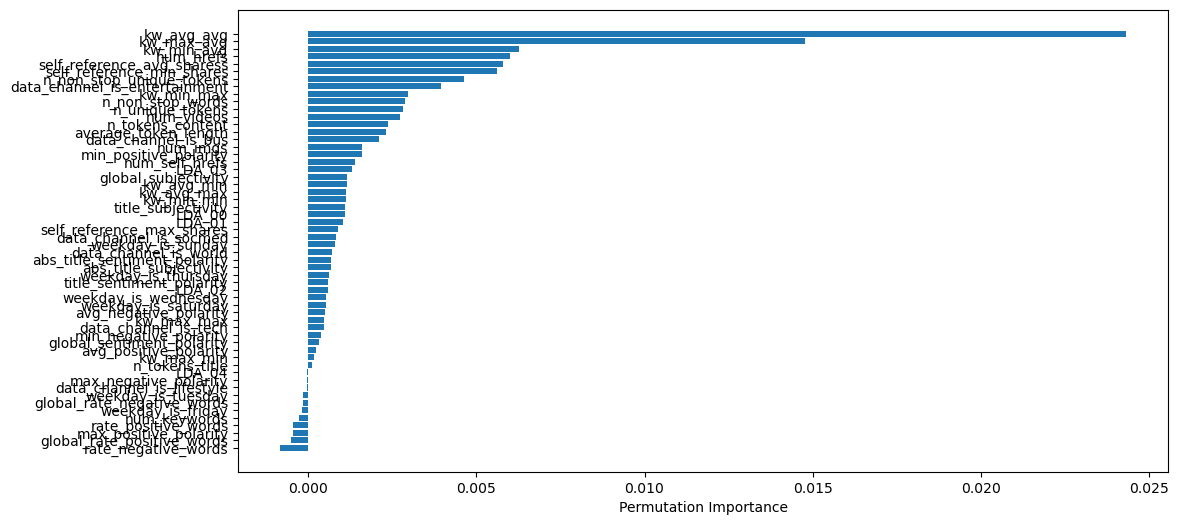

In [33]:
# Choose a model (for example, M1 EBM) and its features for illustration
ebm = ExplainableBoostingClassifier(random_state=20240325)
ebm.fit(X_train[models['M7']], y_train)

# Compute permutation-based feature importance
perm_importance = permutation_importance(ebm, X_val[models['M7']], y_val, n_repeats=10, random_state=42, scoring='roc_auc')

# Retrieve and display feature importances
feature_names = np.array(models['M7'])
sorted_idx = perm_importance.importances_mean.argsort()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()


In [34]:
# Assuming perm_importance is calculated as shown previously
feature_names = np.array(models['M7'])  # Adjust to use the correct model features as needed

# Identify features with positive permutation importance values
positive_importance_features = feature_names[perm_importance.importances_mean > 0]

# Print out the feature names
print("Features with positive permutation importance:")
for feature in positive_importance_features:
    print(feature)

# Create a variable group with these features
perm_importance_positive = positive_importance_features.tolist()

print("Variable group with positive permutation importance:")
print(perm_importance_positive)


Features with positive permutation importance:
n_tokens_title
n_tokens_content
n_unique_tokens
n_non_stop_words
n_non_stop_unique_tokens
average_token_length
num_hrefs
num_self_hrefs
num_imgs
num_videos
global_subjectivity
global_sentiment_polarity
kw_min_min
kw_max_min
kw_avg_min
kw_min_max
kw_max_max
kw_avg_max
kw_min_avg
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
weekday_is_wednesday
weekday_is_thursday
weekday_is_saturday
weekday_is_sunday
data_channel_is_entertainment
data_channel_is_bus
data_channel_is_socmed
data_channel_is_tech
data_channel_is_world
LDA_00
LDA_01
LDA_02
LDA_03
avg_positive_polarity
min_positive_polarity
avg_negative_polarity
min_negative_polarity
title_subjectivity
title_sentiment_polarity
abs_title_subjectivity
abs_title_sentiment_polarity
Variable group with positive permutation importance:
['n_tokens_title', 'n_tokens_content', 'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens', 'averag

### Adjusted EBM 1
---

In [91]:
for group_name, features in models.items():
    start_time = time.time()  # Timer start

    # Adjusted EBM pipeline without SimpleImputer for numerical data
    ebm_adjusted = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.01,
        max_bins=256,
        interactions=10,
        early_stopping_rounds=50
    )

    ebm_adjusted.fit(X_train[features], y_train)

    # Predict probabilities for the positive class
    train_prob = ebm_adjusted.predict_proba(X_train[features])[:, 1]
    val_prob = ebm_adjusted.predict_proba(X_val[features])[:, 1]

    # Calculate AUC scores using the probabilities
    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)
    
    # Calculate RMSLE
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    # Append results
    new_row = pd.DataFrame([[f"{group_name} EBM Adjusted 1", train_auc, val_auc, train_rmsle, val_rmsle]],
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()  # End timer
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 in 3.78 seconds
Completed M2 in 4.49 seconds
Completed M3 in 6.01 seconds
Completed M4 in 6.79 seconds
Completed M5 in 7.31 seconds
Completed M6 in 11.07 seconds
Completed M7 in 12.10 seconds
Completed M8 in 12.72 seconds
Completed M9 in 13.80 seconds
Completed M10 in 18.75 seconds
Completed M11 in 20.41 seconds
Completed M12 in 10.72 seconds
Completed M13 in 15.26 seconds
Completed M14 in 15.48 seconds
Completed M15 in 17.29 seconds
Completed M16 in 18.06 seconds
Completed M17 in 18.33 seconds
Completed M18 in 27.70 seconds
Completed M19 in 27.67 seconds
Completed M20 in 34.47 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
142,M1 EBM Adjusted 1,0.636023,0.607193,0.2242,0.2297,NaN,NaN,NaN,NaN
143,M2 EBM Adjusted 1,0.678342,0.658737,0.2218,0.2277,NaN,NaN,NaN,NaN
144,M3 EBM Adjusted 1,0.718354,0.709401,0.2193,0.2243,NaN,NaN,NaN,NaN
145,M4 EBM Adjusted 1,0.728440,0.718318,0.2185,0.2239,NaN,NaN,NaN,NaN
146,M5 EBM Adjusted 1,0.729174,0.719371,0.2184,0.2238,NaN,NaN,NaN,NaN
147,M6 EBM Adjusted 1,0.741476,0.724784,0.2172,0.2235,NaN,NaN,NaN,NaN
148,M7 EBM Adjusted 1,0.742880,0.725028,0.2170,0.2233,NaN,NaN,NaN,NaN
149,M8 EBM Adjusted 1,0.743572,0.725698,0.2169,0.2233,NaN,NaN,NaN,NaN
150,M9 EBM Adjusted 1,0.738593,0.726296,0.2175,0.2232,NaN,NaN,NaN,NaN
151,M10 EBM Adjusted 1,0.739305,0.727329,0.2174,0.2231,NaN,NaN,NaN,NaN


### Adjusted EBM 2
---

In [92]:
for group_name, features in models.items():
    start_time = time.time()

    ebm_more_adjusted = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.005,  # Slightly lower learning rate for more fine-grained adjustments
        max_bins=512,  # Increased number of bins for potentially capturing more detail
        interactions=15,  # Allowing for more interactions
        early_stopping_rounds=100,  # More patience on early stopping to allow more rounds for convergence
        n_jobs=-1  # Utilize all CPU cores for faster training
    )

    ebm_more_adjusted.fit(X_train[features], y_train)

    train_prob = ebm_more_adjusted.predict_proba(X_train[features])[:, 1]
    val_prob = ebm_more_adjusted.predict_proba(X_val[features])[:, 1]

    train_auc = roc_auc_score(y_train, train_prob)
    val_auc = roc_auc_score(y_val, val_prob)

    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)

    new_row = pd.DataFrame([[f"{group_name} EBM Adjusted 2", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {group_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 in 7.37 seconds
Completed M2 in 8.03 seconds
Completed M3 in 9.96 seconds
Completed M4 in 10.81 seconds
Completed M5 in 11.95 seconds
Completed M6 in 16.96 seconds
Completed M7 in 17.96 seconds
Completed M8 in 19.12 seconds
Completed M9 in 21.31 seconds
Completed M10 in 27.38 seconds
Completed M11 in 29.45 seconds
Completed M12 in 15.95 seconds
Completed M13 in 22.36 seconds
Completed M14 in 23.72 seconds
Completed M15 in 25.11 seconds
Completed M16 in 26.26 seconds
Completed M17 in 27.04 seconds
Completed M18 in 42.42 seconds
Completed M19 in 41.56 seconds
Completed M20 in 51.79 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
162,M1 EBM Adjusted 2,0.640790,0.604144,0.2240,0.2297,NaN,NaN,NaN,NaN
163,M2 EBM Adjusted 2,0.685208,0.658450,0.2213,0.2277,NaN,NaN,NaN,NaN
164,M3 EBM Adjusted 2,0.725316,0.712219,0.2187,0.2240,NaN,NaN,NaN,NaN
165,M4 EBM Adjusted 2,0.735612,0.719000,0.2175,0.2238,NaN,NaN,NaN,NaN
166,M5 EBM Adjusted 2,0.736297,0.719678,0.2176,0.2237,NaN,NaN,NaN,NaN
167,M6 EBM Adjusted 2,0.745007,0.722964,0.2167,0.2235,NaN,NaN,NaN,NaN
168,M7 EBM Adjusted 2,0.746603,0.725448,0.2165,0.2233,NaN,NaN,NaN,NaN
169,M8 EBM Adjusted 2,0.746996,0.725894,0.2164,0.2233,NaN,NaN,NaN,NaN
170,M9 EBM Adjusted 2,0.743411,0.725140,0.2170,0.2233,NaN,NaN,NaN,NaN
171,M10 EBM Adjusted 2,0.740707,0.724105,0.2173,0.2233,NaN,NaN,NaN,NaN


## Neural Network Models
---

In [37]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

n_features = X_train.shape[1]
    
# Reshape your data accordingly
X_train_reshaped = X_train_scaled.reshape((-1, n_features, 1)) 
X_val_reshaped = X_val_scaled.reshape((-1, n_features, 1))

### Simple Neural Network Model 1
---

In [38]:
for model_name, features in models.items():
    start_time = time.time()  # Timer start
    
    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True, mode='max')])

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    new_row = pd.DataFrame([[f"{group_name} NN Simple", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()  # End timer
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)

Completed M1 in 7.94 seconds
Completed M2 in 5.95 seconds
Completed M3 in 7.56 seconds
Completed M4 in 6.04 seconds
Completed M5 in 10.24 seconds
Completed M6 in 5.18 seconds
Completed M7 in 8.67 seconds
Completed M8 in 5.97 seconds
Completed M9 in 5.14 seconds
Completed M10 in 6.76 seconds
Completed M11 in 5.30 seconds
Completed M12 in 8.73 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
204,M12 NN Simple,0.753368,0.691490,0.2165,0.2232
205,M12 NN Simple,0.734512,0.694738,0.2165,0.2232
206,M12 NN Simple,0.747556,0.699987,0.2165,0.2232
207,M12 NN Simple,0.735393,0.695243,0.2165,0.2232
208,M12 NN Simple,0.767811,0.703482,0.2165,0.2232
209,M12 NN Simple,0.728266,0.700289,0.2165,0.2232
210,M12 NN Simple,0.756655,0.698218,0.2165,0.2232
211,M12 NN Simple,0.728137,0.694414,0.2165,0.2232
212,M12 NN Simple,0.728381,0.700328,0.2165,0.2232
213,M12 NN Simple,0.740340,0.699462,0.2165,0.2232


### Simple Neural Network Model 2
---

In [39]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.5),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')])

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    new_row = pd.DataFrame([[f"{group_name} NN Simple 2", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(12)


Completed M1 in 20.94 seconds
Completed M2 in 17.85 seconds
Completed M3 in 22.33 seconds
Completed M4 in 20.92 seconds
Completed M5 in 22.06 seconds
Completed M6 in 29.95 seconds
Completed M7 in 23.64 seconds
Completed M8 in 29.25 seconds
Completed M9 in 22.14 seconds
Completed M10 in 20.30 seconds
Completed M11 in 29.92 seconds
Completed M12 in 19.13 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
216,M12 NN Simple 2,0.729791,0.713079,0.2165,0.2232
217,M12 NN Simple 2,0.723763,0.716836,0.2165,0.2232
218,M12 NN Simple 2,0.734019,0.715555,0.2165,0.2232
219,M12 NN Simple 2,0.730340,0.716712,0.2165,0.2232
220,M12 NN Simple 2,0.732539,0.718642,0.2165,0.2232
221,M12 NN Simple 2,0.739551,0.715059,0.2165,0.2232
222,M12 NN Simple 2,0.730398,0.712880,0.2165,0.2232
223,M12 NN Simple 2,0.739694,0.721339,0.2165,0.2232
224,M12 NN Simple 2,0.735000,0.717972,0.2165,0.2232
225,M12 NN Simple 2,0.729035,0.718677,0.2165,0.2232


### Simple Neural Network Model 3
---

In [40]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')
    model.fit(X_train_scaled, y_train, epochs=150, batch_size=64, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[es])

    train_pred = model.predict(X_train_scaled).flatten()
    val_pred = model.predict(X_val_scaled).flatten()

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(y_train, np.clip(train_pred, 0, None))  # Clipping predictions to ensure non-negative values
    val_rmsle = calculateRMSLE(y_val, np.clip(val_pred, 0, None))
    
    new_row = pd.DataFrame([[f"{model_name} NN Simple 3", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
Completed M1 in 24.59 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
Completed M2 in 15.49 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
Completed M3 in 20.71 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
Completed M4 in 17.68 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step
Completed M5 in 18.34 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
Completed M6 in 18.86 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step
Completed M7 in 18.82 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 834us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
Completed M8 in 15.28 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
228,M1 NN Simple 3,0.766109,0.717128,0.2201,0.2289
229,M2 NN Simple 3,0.741985,0.717268,0.2201,0.2257
230,M3 NN Simple 3,0.761499,0.716094,0.2172,0.2252
231,M4 NN Simple 3,0.750445,0.708730,0.2208,0.2277
232,M5 NN Simple 3,0.750369,0.717170,0.2173,0.2249
233,M6 NN Simple 3,0.753867,0.712930,0.2171,0.2252
234,M7 NN Simple 3,0.751309,0.717229,0.2160,0.2234
235,M8 NN Simple 3,0.738585,0.715592,0.2183,0.2244
236,M9 NN Simple 3,0.747751,0.715073,0.2214,0.2277
237,M10 NN Simple 3,0.769224,0.715751,0.2167,0.2261


### Complex Neural Network Model
---

In [41]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0,
              validation_data=(X_val_scaled, y_val),
              callbacks=[EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True, mode='max')])

    _, train_auc = model.evaluate(X_train_scaled, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    train_rmsle = calculateRMSLE(train_prob, y_train)
    val_rmsle = calculateRMSLE(val_prob, y_val)
    
    new_row = pd.DataFrame([[f"{group_name} NN Complex", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


Completed M1 in 31.81 seconds
Completed M2 in 31.14 seconds
Completed M3 in 35.66 seconds
Completed M4 in 36.62 seconds
Completed M5 in 22.82 seconds
Completed M6 in 31.23 seconds
Completed M7 in 17.98 seconds
Completed M8 in 35.66 seconds
Completed M9 in 37.41 seconds
Completed M10 in 33.76 seconds
Completed M11 in 31.60 seconds
Completed M12 in 33.81 seconds


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
240,M12 NN Complex,0.740095,0.716380,0.2165,0.2232
241,M12 NN Complex,0.746038,0.713890,0.2165,0.2232
242,M12 NN Complex,0.753014,0.715942,0.2165,0.2232
243,M12 NN Complex,0.754655,0.718115,0.2165,0.2232
244,M12 NN Complex,0.727232,0.712990,0.2165,0.2232
245,M12 NN Complex,0.744090,0.717016,0.2165,0.2232
246,M12 NN Complex,0.717489,0.709200,0.2165,0.2232
247,M12 NN Complex,0.751944,0.717043,0.2165,0.2232
248,M12 NN Complex,0.754932,0.718685,0.2165,0.2232
249,M12 NN Complex,0.748170,0.717130,0.2165,0.2232


### Conv1D Adjusted Neural Network 1
---

In [42]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        # Applying Conv1D on the reshaped data; treating each feature as a timestep
        Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(n_features, 1)),
        MaxPooling1D(pool_size=2, strides=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max')
    model.fit(X_train_reshaped, y_train, epochs=200, batch_size=32, verbose=0,
              validation_data=(X_val_reshaped, y_val),
              callbacks=[es])

    _, train_auc = model.evaluate(X_train_reshaped, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_reshaped, y_val, verbose=0)

    # Prediction and RMSLE calculation need correct predictions
    train_pred = model.predict(X_train_reshaped).flatten()
    val_pred = model.predict(X_val_reshaped).flatten()

    train_rmsle = calculateRMSLE(y_train, np.clip(train_pred, 0, None))
    val_rmsle = calculateRMSLE(y_val, np.clip(val_pred, 0, None))

    new_row = pd.DataFrame([[f"{model_name} NN Conv1D Adjusted", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M1 in 49.27 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M2 in 56.74 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M3 in 55.60 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M4 in 54.81 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M5 in 68.01 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M6 in 66.95 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M7 in 50.49 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M8 in 69.91 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M9 in 58.99 

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
252,M1 NN Conv1D Adjusted,0.727281,0.713100,0.2241,0.2287
253,M2 NN Conv1D Adjusted,0.742583,0.714288,0.2172,0.2244
254,M3 NN Conv1D Adjusted,0.738030,0.714907,0.2171,0.2241
255,M4 NN Conv1D Adjusted,0.733848,0.712895,0.2159,0.2228
256,M5 NN Conv1D Adjusted,0.744338,0.712598,0.2157,0.2241
257,M6 NN Conv1D Adjusted,0.751101,0.713787,0.2154,0.2241
258,M7 NN Conv1D Adjusted,0.727315,0.712821,0.2169,0.2231
259,M8 NN Conv1D Adjusted,0.749883,0.713408,0.2149,0.2241
260,M9 NN Conv1D Adjusted,0.739345,0.712111,0.2185,0.2256
261,M10 NN Conv1D Adjusted,0.736992,0.714451,0.2229,0.2291


### Conv1D Adjusted Neural Network 2
---

In [43]:
for model_name, features in models.items():
    start_time = time.time()
    
    model = Sequential([
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_features, 1)), 
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=1, activation='relu'),  # Additional Conv layer
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),  # Slightly increased dropout
        Dense(64, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0005),  # Increased learning rate
                  loss='binary_crossentropy', metrics=[AUC(name='auc')])
    
    es = EarlyStopping(monitor='val_auc', patience=10, restore_best_weights=True, mode='max')  # Adjusted patience
    model.fit(X_train_reshaped, y_train, epochs=100, batch_size=64, verbose=0,  # Reduced epochs, increased batch size
              validation_data=(X_val_reshaped, y_val),
              callbacks=[es])

    _, train_auc = model.evaluate(X_train_reshaped, y_train, verbose=0)
    _, val_auc = model.evaluate(X_val_reshaped, y_val, verbose=0)

    train_pred = model.predict(X_train_reshaped).flatten()
    val_pred = model.predict(X_val_reshaped).flatten()

    train_rmsle = calculateRMSLE(y_train, np.clip(train_pred, 0, None))
    val_rmsle = calculateRMSLE(y_val, np.clip(val_pred, 0, None))

    new_row = pd.DataFrame([[f"{model_name} NN Conv1D Optimized 2", train_auc, val_auc, train_rmsle, val_rmsle]], 
                           columns=['Model', 'Training AUC', 'Validation AUC', 'Training RMSLE', 'Validation RMSLE'])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

    end_time = time.time()
    print(f"Completed {model_name} in {end_time - start_time:.2f} seconds")

results_df.tail(20)


744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M1 in 59.23 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M2 in 63.21 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M3 in 59.74 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M4 in 54.81 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M5 in 48.63 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M6 in 44.04 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M7 in 64.78 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Completed M8 in 38.21 seconds
744/744 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Completed M9 in 54.32 

,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE
264,M1 NN Conv1D Optimized 2,0.740875,0.710798,0.2161,0.2238
265,M2 NN Conv1D Optimized 2,0.746983,0.714292,0.2165,0.2251
266,M3 NN Conv1D Optimized 2,0.742277,0.714361,0.2182,0.2249
267,M4 NN Conv1D Optimized 2,0.733541,0.712576,0.2213,0.2271
268,M5 NN Conv1D Optimized 2,0.727678,0.713164,0.2183,0.2239
269,M6 NN Conv1D Optimized 2,0.726252,0.712681,0.2176,0.2234
270,M7 NN Conv1D Optimized 2,0.750280,0.713523,0.2141,0.2238
271,M8 NN Conv1D Optimized 2,0.718977,0.712242,0.2207,0.2251
272,M9 NN Conv1D Optimized 2,0.740577,0.712769,0.2163,0.2237
273,M10 NN Conv1D Optimized 2,0.728918,0.712726,0.2208,0.2261


# Hypertuning
---

## Feature Importance

# Model Selection
---

In [93]:
# Add a 'Difference AUC' column to measure overfitting
results_df['Difference AUC'] = abs(results_df['Training AUC'] - results_df['Validation AUC'])

# Add a 'Complexity' column based on the model name. Assuming 'M1' is simpler than 'M11'.
results_df['Complexity'] = results_df['Model'].apply(lambda x: int(x.split()[0][1:]))

# Sort by Validation AUC (desc), then by Difference AUC (asc), then by Complexity (asc)
sorted_results_df = results_df.sort_values(by=['Validation AUC', 'Difference AUC', 'Complexity'], ascending=[False, True, True])

# Get the top 20 models
top_20_models = sorted_results_df.head(20)
top_20_models


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
180,M19 EBM Adjusted 2,0.756544,0.729734,0.2153,0.2230,0.026810,19,NaN,NaN
160,M19 EBM Adjusted 1,0.753422,0.728563,0.2156,0.2230,0.024858,19,NaN,NaN
179,M18 EBM Adjusted 2,0.759832,0.728308,0.2149,0.2231,0.031524,18,NaN,NaN
181,M20 EBM Adjusted 2,0.753729,0.728196,0.2156,0.2230,0.025534,20,NaN,NaN
130,M9 EBM,0.762717,0.728033,0.2141,0.2232,0.034684,9,0.538843,0.671276
161,M20 EBM Adjusted 1,0.748417,0.727667,0.2164,0.2230,0.020750,20,NaN,NaN
128,M7 EBM,0.765401,0.727386,0.2137,0.2232,0.038015,7,0.538843,0.670823
151,M10 EBM Adjusted 1,0.739305,0.727329,0.2174,0.2231,0.011977,10,NaN,NaN
159,M18 EBM Adjusted 1,0.755229,0.727098,0.2155,0.2231,0.028131,18,NaN,NaN
139,M18 EBM,0.783207,0.727065,0.2114,0.2233,0.056142,18,0.538636,0.670536


In [94]:
# Sorting models by Validation RMSLE (ascending), then by Validation AUC (descending) for a focus on prediction accuracy
sorted_by_rmsle_df = results_df.sort_values(by=['Validation RMSLE', 'Validation AUC'], ascending=[True, False])

# Get the top 10 models focused on RMSLE
top_20_models_rmsle = sorted_by_rmsle_df.head(20)
print("Top 20 Models Sorted by RMSLE:")
top_20_models_rmsle


Top 20 Models Sorted by RMSLE:


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
180,M19 EBM Adjusted 2,0.756544,0.729734,0.2153,0.2230,0.026810,19,NaN,NaN
160,M19 EBM Adjusted 1,0.753422,0.728563,0.2156,0.2230,0.024858,19,NaN,NaN
181,M20 EBM Adjusted 2,0.753729,0.728196,0.2156,0.2230,0.025534,20,NaN,NaN
161,M20 EBM Adjusted 1,0.748417,0.727667,0.2164,0.2230,0.020750,20,NaN,NaN
179,M18 EBM Adjusted 2,0.759832,0.728308,0.2149,0.2231,0.031524,18,NaN,NaN
151,M10 EBM Adjusted 1,0.739305,0.727329,0.2174,0.2231,0.011977,10,NaN,NaN
159,M18 EBM Adjusted 1,0.755229,0.727098,0.2155,0.2231,0.028131,18,NaN,NaN
131,M10 EBM,0.766798,0.726993,0.2136,0.2231,0.039804,10,0.539050,0.670610
136,M15 EBM,0.760804,0.726864,0.2144,0.2231,0.033939,15,0.539050,0.670520
152,M11 EBM Adjusted 1,0.738411,0.726542,0.2175,0.2231,0.011869,11,NaN,NaN


In [95]:
# Normalize RMSLE (assuming lower is better and to align with AUC's higher is better)
max_rmsle = results_df['Validation RMSLE'].max()
results_df['Normalized RMSLE'] = 1 - (results_df['Validation RMSLE'] / max_rmsle)

# Simple combined score (example: 70% weight on AUC, 30% weight on Normalized RMSLE)
results_df['Combined Score'] = 0.7 * results_df['Validation AUC'] + 0.3 * results_df['Normalized RMSLE']

# Sort by combined score (descending)
sorted_by_combined_score_df = results_df.sort_values(by='Combined Score', ascending=False)

# Get the top 20 models based on the combined score
top_20_models_combined = sorted_by_combined_score_df.head(20)
print("Top 20 Models Sorted by Combined Score (AUC & RMSLE):")
top_20_models_combined


Top 20 Models Sorted by Combined Score (AUC & RMSLE):


,Model,Training AUC,Validation AUC,Training RMSLE,Validation RMSLE,Difference AUC,Complexity,Normalized RMSLE,Combined Score
180,M19 EBM Adjusted 2,0.756544,0.729734,0.2153,0.2230,0.026810,19,0.539256,0.672591
160,M19 EBM Adjusted 1,0.753422,0.728563,0.2156,0.2230,0.024858,19,0.539256,0.671771
179,M18 EBM Adjusted 2,0.759832,0.728308,0.2149,0.2231,0.031524,18,0.539050,0.671530
181,M20 EBM Adjusted 2,0.753729,0.728196,0.2156,0.2230,0.025534,20,0.539256,0.671514
130,M9 EBM,0.762717,0.728033,0.2141,0.2232,0.034684,9,0.538843,0.671276
161,M20 EBM Adjusted 1,0.748417,0.727667,0.2164,0.2230,0.020750,20,0.539256,0.671144
151,M10 EBM Adjusted 1,0.739305,0.727329,0.2174,0.2231,0.011977,10,0.539050,0.670845
128,M7 EBM,0.765401,0.727386,0.2137,0.2232,0.038015,7,0.538843,0.670823
159,M18 EBM Adjusted 1,0.755229,0.727098,0.2155,0.2231,0.028131,18,0.539050,0.670683
131,M10 EBM,0.766798,0.726993,0.2136,0.2231,0.039804,10,0.539050,0.670610


# Test Set Prediction
---

In [65]:
def prediction_folder(day):
    folder_path = f'Predictions/Day_{day}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

### Prediction Functions
---

Since some models are repeated frequently, it will clean up the code to utilize functions.

#### Simple EBM Prediction Function
---

In [47]:
def simple_ebm_prediction(model, day):
    features = models[model]

    # Training the "M9" EBM model
    ebm = ExplainableBoostingClassifier(random_state=20240325)
    ebm.fit(X_train[features], y_train)

    X_test = test_data[features]

    # Predicting with the model
    test_data['score'] = ebm.predict_proba(X_test)[:, 1]

    # Saving the required predictions
    test_data[['article_id', 'score']].to_csv(f'Predictions/Day_{day}/{model}_ebm_predictions.csv', index=False)


#### Adjusted EBM 1 Prediction Function
---

In [48]:
def ebm_adjusted_1_prediction(model, day):
    features = models[model]

    # Adjusted EBM Model 1
    ebm_adjusted_1 = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.01,
        max_bins=256,
        interactions=10,
        early_stopping_rounds=50
    )
    ebm_adjusted_1.fit(X_train[features], y_train)

    X_test = test_data[features]

    # Predicting with the model
    test_data['score'] = ebm_adjusted_1.predict_proba(X_test)[:, 1]

    # Saving the required predictions
    test_data[['article_id', 'score']].to_csv(f'Predictions/Day_{day}/{model}_ebm_adjusted_1_predictions.csv', index=False)


#### Adjusted EBM 2 Prediction Function
---

In [49]:
def ebm_adjusted_2_prediction(model, day):
    features = models[model]

    # Adjusted EBM Model 2
    ebm_adjusted_2 = ExplainableBoostingClassifier(
        random_state=20240325,
        learning_rate=0.005,
        max_bins=512,
        interactions=15,
        early_stopping_rounds=100,
        n_jobs=-1  # Utilize all available CPU cores
    )
    ebm_adjusted_2.fit(X_train[features], y_train)

    X_test = test_data[features]

    # Predicting with the model
    test_data['score'] = ebm_adjusted_2.predict_proba(X_test)[:, 1]

    # Saving the required predictions
    test_data[['article_id', 'score']].to_csv(f'Predictions/Day_{day}/{model}_ebm_adjusted_2_predictions.csv', index=False)


## Day 1 Predictions
---

All of the predictions from day one came from the simple EBM model

In [66]:
prediction_folder('1')

### Simple EBM M9 Prediction 
---

In [50]:
simple_ebm_prediction('M9', '1')

### Simple EBM M7 Prediction
---

In [51]:
simple_ebm_prediction('M7', '1')

### Simple EBM M10 Prediction
---

In [52]:
simple_ebm_prediction('M10', '1')

### Simple EBM M6 Prediction
---

In [53]:
simple_ebm_prediction('M6', '1')

### Simple EBM M12 Prediction
---

In [54]:
simple_ebm_prediction('M12', '1')

## Day 2 Predictions
---

In [ ]:
prediction_folder('2')

### Simple EBM M11 Prediction
---

In [55]:
simple_ebm_prediction('M11', '2')

### Adjusted EBM 1 M10 Prediction
---

In [56]:
ebm_adjusted_1_prediction('M10', '2')

### Adjusted EBM 1 M11 Prediction
---

In [57]:
ebm_adjusted_1_prediction('M11', '2')

### Adjusted EBM 1 M12 Prediction
---

In [58]:
ebm_adjusted_1_prediction('M12', '2')

### Adjusted EBM 1 M9 Prediction
---

In [59]:
ebm_adjusted_1_prediction('M9', '2')

## Day 3 Predictions
---

In [67]:
prediction_folder('3')

In [96]:
ebm_adjusted_1_prediction('M19', '3')

In [97]:
ebm_adjusted_2_prediction('M18', '3')

In [98]:
ebm_adjusted_2_prediction('M19', '3')

In [99]:
ebm_adjusted_2_prediction('M20', '3')

In [102]:
simple_ebm_prediction('M18', '3')

## Day 4 Predictions
---

In [101]:
prediction_folder('4')